![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# *Final Project: Contextual Bandits - Algorithm Analysis*

## Reinforcement Learning

#### Authors: **Timothy Cassel, Marvin Ernst, Oliver Tausendschön**

Date: July 2, 2025

Instructors: *Hamish Flynn and Vincent Adam*

In this notebook, we evaluate and analyze contextual bandit algorithms using the **Open Bandit Dataset (OBD)**. The main focus lies on implementing and benchmarking **LinUCB**, a classic contextual bandit algorithm, under realistic conditions with logged bandit feedback.

We perform the following:
- Run **LinUCB** with varying exploration parameters on real logged interactions
- Evaluate performance using **offline policy evaluation (OPE)** techniques:
  - Cumulative reward comparison under logged actions
  - **Inverse Propensity Scoring (IPS)**
  - **Doubly Robust (DR)** estimators
- Compare our custom implementation to the official `obp` version of LinUCB
- Analyze action selection behavior, learning curves, and OPE bias

This notebook provides empirical insights into the challenges and opportunities of offline learning from bandit data in recommendation systems.

---

Importing the relevant libraries and functions:

In [1]:
from load_opb import load_obp_dataset
from linucb import linucb_all

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from numpy.random import default_rng

from evaluate.evaluate_random_policy import evaluate_random_policy
import os

## 1. Loading Data

We utilize the `load_obp_dataset()` function from `load_opb.py`, which originally loads the OBP data for a specific campaign and behavior policy (e.g., `'random'` or `'bts'`). It retrieves the **context vectors** (features), **actions**, **rewards**, and **propensity scores** (i.e., the probability that the behavior policy selected the given action under the context).

These components are essential for **offline policy evaluation**, where we aim to estimate how well a new policy would perform based only on logged interaction data.

In this notebook, we use a **preprocessed and reduced OBP-style dataset**, where:
- Sparse context features were dropped, and dimensionality was reduced to **12** using PCA
- Only **3 actions** were retained (3 most-clicked arms)
- All interactions involving those selected arms were preserved

To reduce IPS variance and accelerate evaluation, we restrict our action space to the **3 most frequently selected arms** under the logging policy. This increases the overlap between the logging and target policies, making offline evaluation more stable while preserving meaningful reward signals.

This reduced version enables faster experimentation while preserving key structural properties for meaningful evaluation.

**We now load this reduced OBP dataset (12-dimensional context, 3 arms):**

In [2]:
context = np.load("processed_top3/context_reduced.npy")
action = np.load("processed_top3/actions.npy")
reward = np.load("processed_top3/rewards.npy")
pscore = np.load("processed_top3/pscores.npy")

The actions and context dimensions:

In [3]:
n_actions = 3
context_dim = context.shape[1]

Confirming the data:

In [4]:
print("Shape of context:", context.shape)
print("Number of actions:", np.unique(action).size)
print("Total observations:", context.shape[0])
print("Click-through rate:", reward.mean().round(4))

Shape of context: (53988, 12)
Number of actions: 3
Total observations: 53988
Click-through rate: 0.0034


## 2. Applying Linear UCB

In this section, we apply our implementation of the **LinUCB** algorithm to the dataset. Before running the algorithm, we must initialize the design matrix **A** and feature vector **b** for each action. These are updated iteratively as LinUCB learns from observed interactions.

- **A**: design matrix (identity matrix), one per action
- **b**: feature vector (zero vector), one per action

We are using the correct LinUCB, where we **only update when LinUCB chose same action as logging policy**. This is an unbiased strategy, compared to using all logged actions/rewards to update LinUCB, which would be biased as it treats actions as if chosen by LinUCB.

We begin with an exploration parameter of **$\alpha = 1.0$**, and later compare different values to understand how exploration affects performance.

#### LinUCB with $\alpha = 1.0$

In [5]:
alpha = 1.0

A = [np.identity(context_dim) for _ in range(n_actions)] 
b = [np.zeros(context_dim) for _ in range(n_actions)] 

results = linucb_all(context, action, reward, A, b, alpha)
for key, value in results.items():
    print(f"{key}: {type(value).__name__}")

theta: list
A: list
b: list
chosen_actions: list
true_actions: ndarray
rewards: ndarray
ucb_scores: list


#### LinUCB with alternative $\alpha$ values

We also run the algorithm with lower α values to compare more exploitative behaviors:

In [6]:
results_01= linucb_all(context, action, reward, A, b, alpha = 0.1)

In [7]:
results_05 = linucb_all(context, action, reward, A, b, alpha = 0.5)

In [8]:
results_00 = linucb_all(context, action, reward, A, b, alpha = 0.0)

## 3. Comparing Actions

We now compare the actions selected by **LinUCB** with those taken by the logging policy (which was uniformly random). At first glance, a low match rate (around 1%) might seem concerning. However, in an **offline bandit setting**, this is expected and not problematic.

Our goal is not to replicate the behavior policy but to **learn a better policy**. Since the logging policy is random, many of its actions are suboptimal. A low overlap simply indicates that LinUCB is making different - and potentially better - decisions.

**Action overlap between LinUCB and the logging policy (first 100 rounds):**

In [9]:
matches = np.array(results["chosen_actions"]) == np.array(results["true_actions"])
cumulative_matches = np.cumsum(matches)
print(f" first few predictions: {results['chosen_actions'][:100]}")
print(f" first few true actions: {results['true_actions'][:100]}")
print(f"Cumulative Matches: {cumulative_matches[:100]}")

 first few predictions: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 0, 2, 2, 2, 2, 0, 0, 1, 0, 2, 2, 0, 2]
 first few true actions: [2 2 2 0 0 0 0 0 0 0 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 2 2 2 2 2 2
 2 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1]
Cumulative Matches: [ 0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  4  5  5  5  6  6  6  6  6  7  8  8  8  8  8  8  9  9  9 10 10
 10 10 10 10]


We can see the **first 3 predicted actions** are simply `[0, 1, 2]`, i.e., each arm is selected once in order. This is expected for UCB, at the beginning, all arms have equal uncertainty and no reward feedback. UCB encourages exploration by selecting each arm at least once to gather initial data.

The **true actions** differ from the predictions, which is expected in offline bandit data where the logging policy (here: random) took different actions.

**Cumulative Mathces Distribution:**

Cumulative Matches:


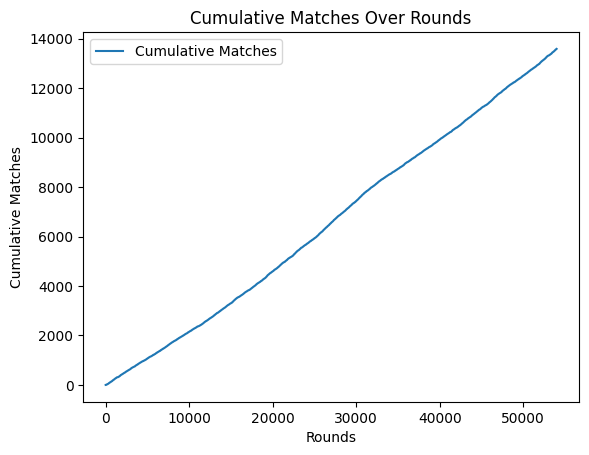

In [10]:
print("Cumulative Matches:")
plt.plot(np.cumsum(matches), label="Cumulative Matches")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Matches")
plt.title("Cumulative Matches Over Rounds")
plt.legend()
plt.show()

This is again show that since it is randome, they do not start to match more over time.

**Action Match Rate Over Time:**

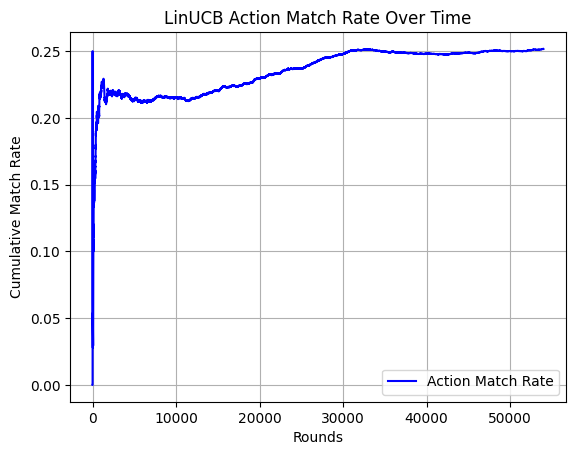

In [11]:
ideal_matches = (np.arange(1, len(matches) + 1))
match_rate_over_time = cumulative_matches / ideal_matches

plt.plot(match_rate_over_time, label='Action Match Rate', color='blue')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Match Rate')
plt.title('LinUCB Action Match Rate Over Time')
plt.legend()
plt.grid(True)
plt.show()

As described above, we can see that LinUCB’s selected actions rarely match those taken by the logging (random) policy. The overall low match rate (about 25%) reflects that LinUCB is learning a **different policy** - which is expected and even desirable in an offline learning context.

Since the logging policy was random, most of its actions are likely suboptimal. A low overlap does not indicate failure - instead, it suggests that LinUCB is making **more informed choices** based on contextual information.

From here on, we will not rely on action matching as a proxy for performance. Instead, we will assess whether LinUCB is actually learning a better policy using **offline policy evaluation methods** such as:

- **Cumulative reward comparison**
- **Inverse Propensity Scoring (IPS)**
- **Doubly Robust (DR) estimators**

##### **Estimated coefficient vectors ($\theta$) for each arm:**

In [12]:
for i, theta in enumerate(results["theta"]):
    print(f"Arm {i} Coefficients: {np.round(theta, 4)}")

Arm 0 Coefficients: [ 0.0021  0.0004 -0.0011 -0.002  -0.0007  0.0071  0.0027 -0.0003  0.0079
 -0.007  -0.0049  0.0102]
Arm 1 Coefficients: [ 0.0005  0.      0.0006 -0.0005 -0.0005 -0.0007 -0.0012  0.0025 -0.0012
  0.0014  0.0002 -0.005 ]
Arm 2 Coefficients: [-0.0031  0.0007 -0.0007 -0.0038 -0.0044  0.0005  0.0032  0.0029 -0.0048
  0.0135  0.0021 -0.0027]


These learned parameter vectors are mostly close to zero, as expected after a single full pass through the data. However, we can observe small deviations, such as positive weights for certain context dimensions in Arm 0 and Arm 2 (e.g., 0.0102, 0.0135), suggesting that **LinUCB has started to identify weak associations** between context features and reward.

This is consistent with expectations in an **offline bandit setting with sparse rewards**: since only a small fraction of actions receive positive reward feedback, most updates are driven by zero reward, making it harder for the model to confidently estimate reward-relevant feature directions. Still, the small coefficient shifts hint at early learning progress.

## 4. Evaluating the Algorithm (offline Bandit evaluation)

To compare the random policy with LinUCB, we begin with a basic offline evaluation setup: LinUCB only receives reward when its chosen action matches the action logged by the random behavior policy. This setup is consistent with how offline bandit data is collected, only the reward for the logged action is observed.

However, this approach is highly biased. Since LinUCB typically selects different actions than the random policy (as we have seen), most of its potentially good decisions are ignored. As a result, the raw cumulative reward curve severely underestimates LinUCB's actual performance, as seen in the plot below.

To correct for this bias, we implement **Inverse Propensity Scoring (IPS)**. IPS reweights the observed rewards based on how likely the logging policy was to take the action. If LinUCB happens to select the same action as the logger, the reward is scaled by the inverse of the logging policy's probability of choosing it. This adjustment helps us estimate the expected performance of LinUCB, even though we only observe feedback for a small fraction of its actions.

### **Basic Logged Evaluation**

In [13]:
linucb_rewards = np.array(results["rewards"]) * matches
linucb_rewards = linucb_rewards.tolist()

nonzero_rewards = [r for r in linucb_rewards if r > 0]
print(f"Number of valid LinUCB rewards > 0: {len(nonzero_rewards)}")
print(nonzero_rewards[:10])

Number of valid LinUCB rewards > 0: 41
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


This gives us 41 non-zero rewards, which reflects the extremely limited overlap between LinUCB’s policy and the random logging policy.

#### Cumulative Reward (Naive Logged Evaluation)

We now compare the cumulative reward of LinUCB (under the offline matching constraint) to the reward accumulated by the logging policy:

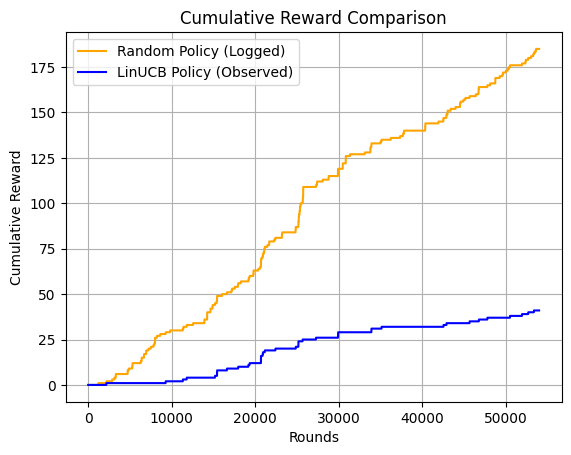

In [14]:
cumulative_random = np.cumsum(reward)
cumulative_linucb = np.cumsum(linucb_rewards)

plt.plot(cumulative_random, label='Random Policy (Logged)', color='orange')
plt.plot(cumulative_linucb, label='LinUCB Policy (Observed)', color='blue')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Comparison')
plt.legend()
plt.grid(True)
plt.show()

As seen in the plot above, LinUCB appears to perform much worse than the logging policy. But this is misleading as the evaluation is biased. This underperformance arises not because LinUCB is bad, but because rewards are only logged for the actions chosen by the random policy, and LinUCB selects different actions in most cases (which we cannot evaluate).

### **Inverse Propensity Scoring (IPS)**

To get a fairer estimate, we turn to Inverse Propensity Scoring (IPS). This technique reweights the observed rewards based on the propensity scores (i.e., the probability that the logging policy selected the observed action).

- If LinUCB selects the same action as the logging policy, we **scale the reward** by the inverse of the logging probability.
- If the actions differ, the reward is zero (no information is available).

This gives us an **unbiased estimate** of LinUCB’s expected reward under the logged bandit data.

In [15]:
chosen_actions = np.array(results["chosen_actions"])
logged_actions = np.array(action)
rewards = np.array(reward)
pscores = np.array(pscore)

LinUCB IPS:

In [16]:
matches = chosen_actions == logged_actions
ips_weights = matches / pscores
ips_estimates = ips_weights * rewards
cumulative_ips = np.cumsum(ips_estimates)

Random Policy IPS estimate (IPS on itself):

In [17]:
random_ips_estimates = rewards / pscores
cumulative_random_ips = np.cumsum(random_ips_estimates)

Logged cumulative reward:

In [18]:
cumulative_logged = np.cumsum(rewards)

Debug:

In [19]:
print(f"IPS Weights (LinUCB): {ips_weights[:10]}")
print(f"IPS Estimates (LinUCB): {ips_estimates[:10]}")
print(f"Total IPS Estimates (LinUCB): {ips_estimates.sum()}")
print(f"Total Random IPS: {random_ips_estimates.sum()}")
print(f"Total Logged: {cumulative_logged[-1]}")

IPS Weights (LinUCB): [ 0.  0.  0. 80.  0.  0.  0.  0.  0.  0.]
IPS Estimates (LinUCB): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total IPS Estimates (LinUCB): 3280.0
Total Random IPS: 14800.0
Total Logged: 185


**Adding Another Random Policy (Evaluation Policy):**

In [20]:
n_actions = len(np.unique(action))
rng = default_rng(seed=42)

Simulate a new random policy:

In [21]:
random_eval_actions = rng.integers(low=0, high=n_actions, size=len(context))

IPS estimate for the new random policy:

In [22]:
matches_eval = random_eval_actions == action
ips_weights_eval = matches_eval / pscore
ips_estimates_eval = ips_weights_eval * reward
cumulative_random_eval_ips = np.cumsum(ips_estimates_eval)

**IPS-Corrected Cumulative Reward**

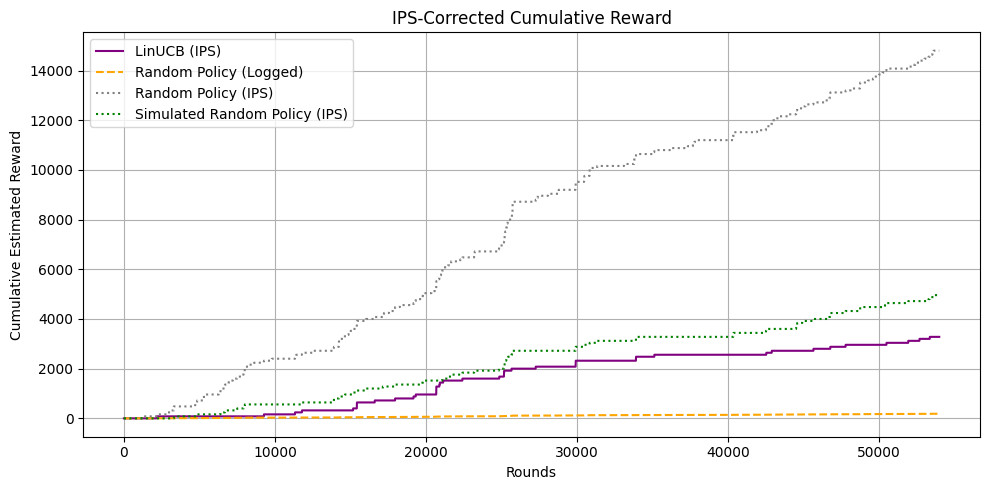

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(cumulative_ips, label="LinUCB (IPS)", color="purple")
plt.plot(cumulative_logged, label="Random Policy (Logged)", color="orange", linestyle="--")
plt.plot(cumulative_random_ips, label="Random Policy (IPS)", color="gray", linestyle=":")
plt.plot(cumulative_random_eval_ips, label="Simulated Random Policy (IPS)", color="green", linestyle=":")
plt.title("IPS-Corrected Cumulative Reward")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Estimated Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Results Interpretation**

The IPS-corrected evaluation reveals that **LinUCB** outperforms the **raw logged random policy**, even though this improvement would be **invisible** without correction. However, we now also include two baselines:

- The **Random Policy (Logged)** is simply the cumulative reward observed from the logging policy—this significantly underestimates the performance of other policies due to missing data for unobserved actions.
- The **Random Policy (IPS)** reweights the logged actions under the assumption that they were sampled from a uniform random policy. This corrects for action-selection bias and produces much higher estimates.
- The **Simulated Random Policy (IPS)** is created by explicitly sampling uniformly from the same action space and applying IPS—providing another baseline for evaluation consistency.

Key takeaways from the plot:

- **LinUCB (purple)** shows meaningful cumulative gain once its chosen actions align with the logging policy.
- **Random Policy (Logged)** (orange) remains low, underestimating all other policies due to partial observability.
- **Random Policy (IPS)** (gray) and **Simulated Random Policy (green)** show much higher cumulative rewards, revealing the actual performance of uniformly random strategies when properly corrected.

Despite sparse rewards and limited overlap, **Inverse Propensity Scoring (IPS)** recovers valuable signal and highlights that **LinUCB learns a better-than-random policy**. The observed **steep jumps** (e.g., around round 20,000) mark successful and rewarding overlaps, heavily reweighted by IPS.

These results validate IPS as a robust offline evaluation approach - particularly important when rewards are sparse and direct comparisons with logged outcomes are misleading.

### **Doubly Robust (DR) Estimators**

While Inverse Propensity Scoring (IPS) already provided a much more accurate estimate of LinUCB’s performance compared to the raw logged rewards, it still relies on action matches between the logging and evaluation policies. When such overlaps are rare, IPS estimates may become high variance or unstable.

To further enhance the reliability of offline evaluation, we now introduce the **Doubly Robust (DR)** estimator. This method combines:
- **Direct Method (DM)**: Uses a learned model to predict the expected reward for any action, even if it wasn't logged.
- **IPS Correction**: When the evaluation policy’s action matches the logged one, DR corrects the model's prediction using the actual observed reward, scaled by the inverse of the logging probability.

This hybrid approach brings the best of both worlds:
- If the model is accurate, DR works well even without action matches.
- If the model is imperfect, but there are matches, DR falls back on observed rewards to remain unbiased.

DR is thus especially valuable in our **offline bandit setting**, where true feedback is only partially observed, and overlap between policies is low. It enables more stable and informative evaluation of learned policies like LinUCB.

**Preparing the Data**

In [24]:
X_context = context 
a_logged = np.array(action)
r_logged = np.array(reward)
pscore = np.array(pscore)
a_target = np.array(results["chosen_actions"]) 

One-hot encode actions:

In [25]:
action_onehot = OneHotEncoder(sparse_output=False)
a_onehot = action_onehot.fit_transform(a_logged.reshape(-1, 1))

Feature matrix: [context | one-hot(action)]

In [26]:
X_train = np.hstack([X_context, a_onehot])
y_reward = r_logged

**Training the Reward Model**

In [27]:
reward_model = RandomForestRegressor(n_estimators=100, random_state=42)
reward_model.fit(X_train, y_reward)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Predict rewards for LinUCB's chosen actions**

In [28]:
a_target_onehot = action_onehot.transform(a_target.reshape(-1, 1))
X_test = np.hstack([X_context, a_target_onehot])
r_hat = reward_model.predict(X_test)

**Predict reward for logged actions**

In [29]:
a_logged_onehot = action_onehot.transform(a_logged.reshape(-1, 1))
X_logged = np.hstack([X_context, a_logged_onehot])
r_hat_random = reward_model.predict(X_logged)

Clipping predicted rewards to a range between 0 and 1:

In [30]:
#r_hat = np.clip(r_hat, 0, 1)
#r_hat_random = np.clip(r_hat_random, 0, 1)

Cumulative expected reward from the random policy (Direct Method):

In [31]:
cumulative_dm_random = np.cumsum(r_hat_random)

**Apply Doubly Robust Estimator**

In [32]:
matches = a_target == a_logged
correction = np.zeros_like(r_logged)
correction[matches] = (r_logged[matches] - r_hat[matches]) / pscore[matches]
# Optional: Clip large values of the correction to reduce extreme variance (not full [0,1])
#max_correction = 10.0  # or log(1 / min(pscore)) approx.
#correction = np.clip(correction, -max_correction, max_correction)
dr_estimates = r_hat + correction
#dr_estimates = np.clip(dr_estimates, 0, 1) # CLIPPING
cumulative_dr = np.cumsum(dr_estimates)

In [33]:
print("Correction stats:")
print("Min:", correction.min())
print("Max:", correction.max())
print("Mean:", correction.mean())

Correction stats:
Min: -18
Max: 79
Mean: 0.03195154478773061


**Compare with Random Logging Policy (baseline)**

In [34]:
cumulative_random = np.cumsum(r_logged)

##### **True Baseline**

We simulate a new random policy, predict rewards for the random policy, and do the DR correction.

**Safe-Way Evaluation for the Random Simulated Policy**

We actually used a different version as previously so there is no seed or model leakage (which can and does sometimes happen when a lot of memory is sued since we load the same RandomForestModel and do not restart the kernel, i.e., the environment). Now, the simulated random policy is computed identically every time:

In [35]:
dr_sim_random = evaluate_random_policy(seed=123)
cumulative_random_eval = np.cumsum(dr_sim_random)

**Intermediate: Check reward model predictions**

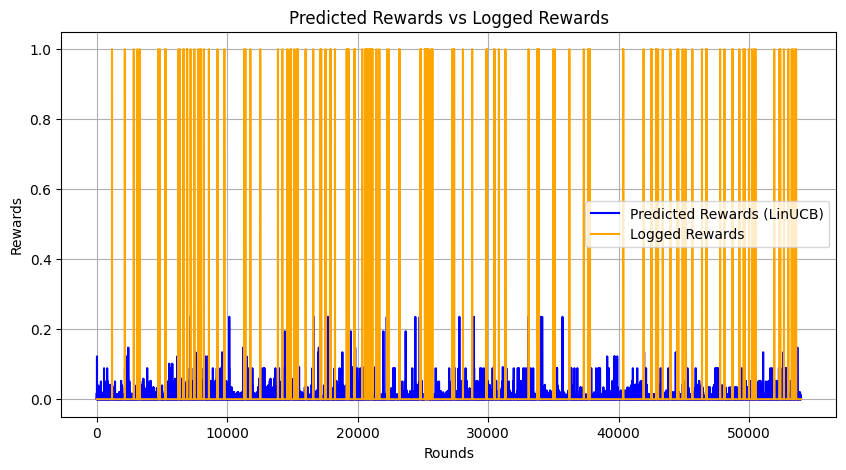

sum of all predicted rewards: 189.01317201363383
sum of all logged rewards: 185


In [36]:
plt.figure(figsize=(10, 5))
plt.plot(r_hat, label="Predicted Rewards (LinUCB)", color="blue")
plt.plot(r_logged, label="Logged Rewards", color="orange")
plt.title("Predicted Rewards vs Logged Rewards")
plt.xlabel("Rounds")
plt.ylabel("Rewards")
plt.legend()
plt.grid(True)
plt.show()

print(f"sum of all predicted rewards: {np.sum(r_hat)}")
print(f"sum of all logged rewards: {np.sum(r_logged)}")

First, we compare the **predicted rewards** from our trained reward model with the actual **logged rewards**. While noisy due to the sparsity of reward signals, we observe that the predicted rewards loosely follow the distribution of logged rewards, indicating that the reward model has captured some useful patterns.

**Comparison Plot - Cumulative Rewards**

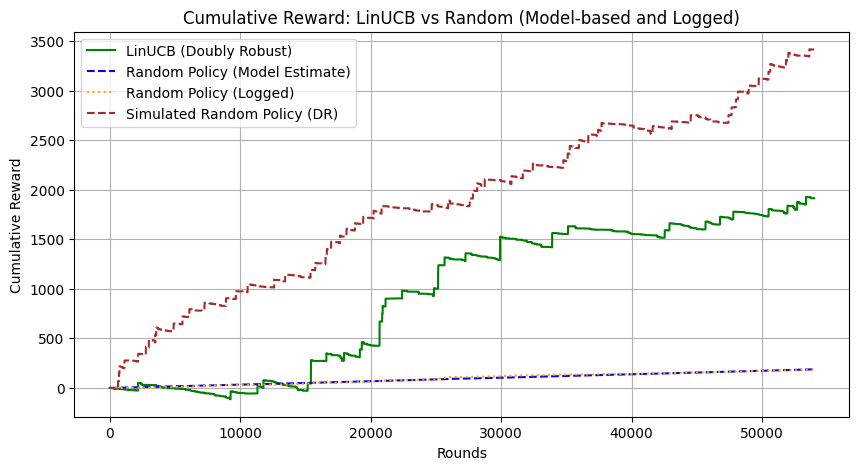

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(cumulative_dr, label="LinUCB (Doubly Robust)", color="green")
plt.plot(cumulative_dm_random, label="Random Policy (Model Estimate)", color="blue", linestyle="--")
plt.plot(np.cumsum(r_logged), label="Random Policy (Logged)", color="orange", linestyle=":")
plt.plot(cumulative_random_eval, label="Simulated Random Policy (DR)", linestyle="--", color="brown")
plt.title("Cumulative Reward: LinUCB vs Random (Model-based and Logged)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()

##### **Results: Doubly Robust (DR) Evaluation**

These results are based on **non-clipped DR estimates**, meaning we allow both the predicted and corrected rewards to go beyond the usual [0, 1] range. While this increases expressiveness, it can also cause **negative cumulative rewards** in early rounds due to overcorrection - particularly when the reward model misestimates outcomes for low-probability actions.

The plot illustrates:

- The **orange dotted line** represents cumulative rewards from the **random logging policy** - i.e., what was actually observed in the dataset.
- The **blue dashed line** shows expected rewards under the logging policy, predicted by the **reward model** (Direct Method).
- The **green solid line** depicts the **Doubly Robust (DR)** estimate for LinUCB, combining model-based predictions with corrections derived from IPS when actions match.
- The **brown dashed line** shows the DR estimate for a **simulated random policy**, which samples actions independently from the logged policy and highlights how reward estimates behave for a purely random decision maker evaluated offline.

**Note:** The logged random policy and the simulated random policy evaluated using DR produce similar results because both select actions uniformly at random from the same set of arms. Since DR relies on observed rewards when the chosen action matches the logged one, both policies effectively use the same subset of matched actions for correction. However, because rewards are only observed for logged actions, both estimates remain biased downward due to limited action overlap and partial observability.

We observe a surprising result:  
> The **simulated random policy (brown)** outperforms **LinUCB (green)** by a large margin.

This occurs because the **simulated random policy's actions are uncorrelated with the logged ones**, but **occasionally match and obtain reward** - and these matches are **heavily upweighted** by the DR correction. Since the simulation explores more uniformly and makes no assumptions about context, it may coincidentally match logged actions with positive rewards more often than LinUCB, especially when LinUCB is being conservative or misled early.

#### Key challenges influencing the results:

1. **Sparse rewards**: Only a small subset of actions yield positive feedback (e.g., clicks).
2. **Low action overlap**: LinUCB often selects actions different from those logged, leading to few direct observations for correction.
3. **Weak context-reward relationship**: Context features may not be informative enough for LinUCB to clearly outperform random selection.

---

##### **Why Use DR?**

Doubly Robust (DR) estimation combines the strengths of both **Inverse Propensity Scoring (IPS)** and the **Direct Method (DM)**:
- When **model predictions are accurate**, DR provides low-variance estimates even when action matches are rare.
- When **action overlap occurs**, DR leverages observed rewards to correct potential model bias.

DR relies on:
- A reasonably accurate **reward model** (for DM predictions),
- Well-calibrated **propensity scores** (for IPS correction when overlaps occur).

In our experiments:
- **IPS** remained highly variable due to **limited overlap** between learned and logged actions.
- **DR** was more stable and interpretable, making it preferable for evaluation in this offline setting.
- The **simulated random policy** highlights how DR correction can amplify reward estimates under rare but high-reward matches.

We therefore choose **Doubly Robust estimation as our primary evaluation metric** going forward - while keeping in mind its **sensitivity to rare matches** and **modeling assumptions**.

We now explore how different values of `alpha` affect policy quality, using **DR-based cumulative reward curves** averaged over multiple simulation runs.

## 5. LinUCB with Different Alpha Values

We now investigate how LinUCB performs under different exploration settings. The parameter $\alpha$ controls the exploration-exploitation tradeoff:

- **$\alpha = 0.0$**: Purely greedy (no exploration)  
- **$\alpha = 0.1$**: Light exploration (mostly exploitative)  
- **$\alpha = 0.5$**: Moderate exploration  
- **$\alpha = 1.0$**: Strong exploration (high uncertainty bonus)  

We evaluate each setting based on a single run and compare their performance using the **Doubly Robust (DR)** estimator.

**DR estimates for each policy (single run):**

In [38]:
results_dict = {
    "LinUCB alpha=0.0": results_00,
    "LinUCB alpha=0.1": results_01,
    "LinUCB alpha=0.5": results_05,
    "LinUCB alpha=1.0": results,
}

dr_curves = {}

for label, res in results_dict.items():
    a_chosen = np.array(res["chosen_actions"])
    a_chosen_onehot = action_onehot.transform(a_chosen.reshape(-1, 1))
    X_eval = np.hstack([X_context, a_chosen_onehot])
    
    r_hat = reward_model.predict(X_eval)
    matches = a_chosen == a_logged
    correction = np.zeros_like(r_logged)
    correction[matches] = (r_logged[matches] - r_hat[matches]) / pscore[matches]
    
    dr_estimates = r_hat + correction
    dr_curves[label] = np.cumsum(dr_estimates)

**Plot**

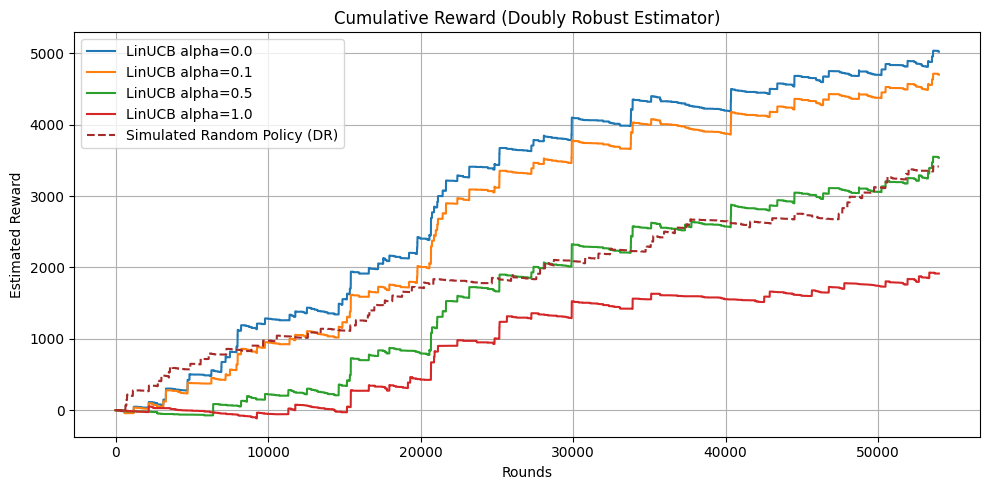

In [39]:
plt.figure(figsize=(10, 5))
for label, curve in dr_curves.items():
    plt.plot(curve, label=label)
plt.plot(cumulative_random_eval, label="Simulated Random Policy (DR)", linestyle="--", color="brown")
plt.title("Cumulative Reward (Doubly Robust Estimator)")
plt.xlabel("Rounds")
plt.ylabel("Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We focus on four $\alpha$ values controlling the exploration-exploitation tradeoff:

- **$\alpha = 0.0$ (greedy)** consistently performs best in this run.
- As $\alpha$ increases, performance drops: strong exploration (e.g., $\alpha = 1.0$) yields slower learning.
- **LinUCB $\alpha=0.1$** strikes a good balance, performing nearly as well as the greedy policy while maintaining some exploration.

We also include the **Simulated Random Policy (DR)** (dashed brown) as a baseline -  this was our fully independent random policy evaluated using the same Doubly Robust estimator.

We observe that we actually manage to beat the true benchmark, when exploration is mall - with moderate exploration $\alpha = 0.5$ we see that it performs as good as just picking arms randomly. With lower $\alpha$ values LinUCB actually achieves higher rewards (evaluated by our DR startegy) as the random policy.

> While this result is based on a **single run**, it suggests that low exploration may be advantageous in this offline setup, possibly due to limited action overlap and sparse reward signals. In the next section, we repeat this over multiple simulations to average out variance.

#### Average Statistics

We evaluate three LinUCB policies ($\alpha = 0.0$, $\alpha = 0.5$, and $\alpha = 1.0$) using **precomputed action trajectories** from a single run of each policy.

To estimate the cumulative reward more robustly, we perform **30 independent simulations** where in each run:
- We shuffle the dataset (contexts, logged actions, rewards, and propensity scores),
- Refit the reward model on the permuted data,
- And apply the same precomputed actions, realigned to the shuffled order.

The Doubly Robust (DR) estimator is then used in each run to compute the cumulative reward curve, and these are averaged across runs. While this does not reflect variability in the policies’ decisions themselves (since the actions are fixed), it does account for randomness in data exposure and reward modeling.

This gives us stable reward estimates under varying training conditions, while **keeping the policy decisions constant** - useful for isolating the effect of stochasticity in logged feedback and reward model fitting.

In [40]:
n_runs = 30
n_rounds = len(context)
context_dim = context.shape[1]

results_dict = {
    "LinUCB alpha=0.0": results_00,
    "LinUCB alpha=0.5": results_05,
    "LinUCB alpha=1.0": results,
}

Initialize average curves:

In [41]:
average_curves = {label: np.zeros(n_rounds) for label in results_dict}

Start repeated evaluation:

In [42]:
for seed in range(n_runs):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n_rounds)

    X_context = context[idx]
    a_logged = np.array(action)[idx]
    r_logged = np.array(reward)[idx]
    pscores = np.array(pscore)[idx]

    onehot = OneHotEncoder(sparse_output=False)
    a_logged_1hot = onehot.fit_transform(a_logged.reshape(-1, 1))

    X_train = np.hstack([X_context, a_logged_1hot])
    reward_model = RandomForestRegressor(n_estimators=100, random_state=seed)
    reward_model.fit(X_train, r_logged)

    for label, res in results_dict.items():
        a_chosen = np.array(res["chosen_actions"])[idx]
        a_chosen_1hot = onehot.transform(a_chosen.reshape(-1, 1))
        X_eval = np.hstack([X_context, a_chosen_1hot])
        r_hat = reward_model.predict(X_eval)

        matches = a_chosen == a_logged
        correction = np.zeros_like(r_logged)
        correction[matches] = (r_logged[matches] - r_hat[matches]) / pscores[matches]
        dr_estimates = r_hat + correction

        average_curves[label] += np.cumsum(dr_estimates)

Normalize:

In [43]:
for label in average_curves:
    average_curves[label] /= n_runs

Compute **simulated random policy DR estimate** (we also save them, so when already computed we can just load them).

To compute the random olicy on average:

In [48]:
!python evaluate/evaluate_random_policy.py

Load precomputed average DR curve for the random policy:

In [44]:
average_simulated_random_dr = np.load("results/dr_random_avg.npy")
print("Shape:", average_simulated_random_dr.shape)
print("Mean DR reward:", average_simulated_random_dr[-1] / len(average_simulated_random_dr))

Shape: (53988,)
Mean DR reward: 0.06683027223120472


**Comparison**

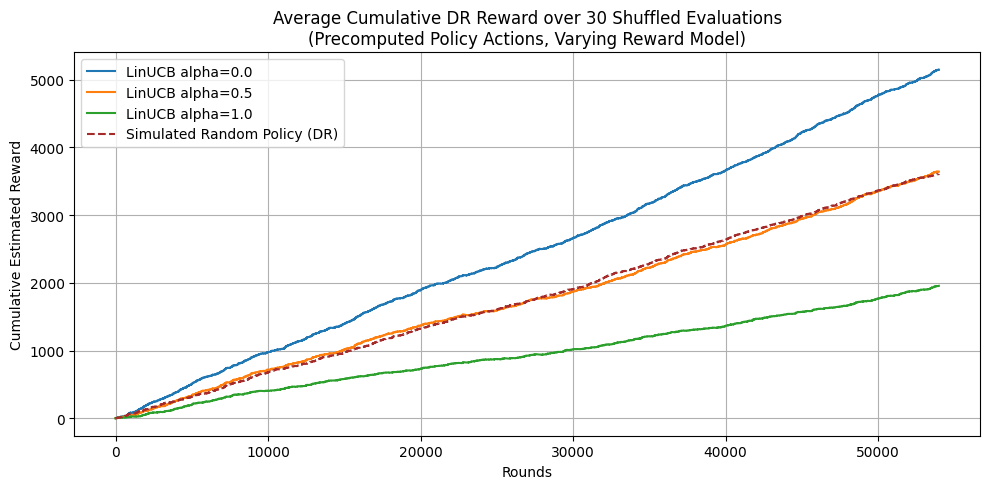

In [45]:
plt.figure(figsize=(10, 5))
for label, curve in average_curves.items():
    plt.plot(curve, label=label)
plt.plot(average_simulated_random_dr, label="Simulated Random Policy (DR)", linestyle="--", color="brown")
plt.title("Average Cumulative DR Reward over 30 Shuffled Evaluations\n(Precomputed Policy Actions, Varying Reward Model)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Interpretation: DR Evaluation of Precomputed LinUCB Policies

This plot shows the **average cumulative DR-estimated reward** for three LinUCB variants:

- **$\alpha = 0.0$ (purely greedy)** performs best, achieving the highest cumulative reward across the entire horizon.
- **$\alpha = 0.5$ (moderate exploration)** performs worse than the greedy policy but better than full exploration.
- **$\alpha = 1.0$ (high exploration)** results in the lowest cumulative reward among the LinUCB policies.

These results are based on **30 repeated DR evaluations** - in each run, we reshuffle the logged data and retrain the reward model, but we **reuse the same precomputed action sequences** from each LinUCB policy.

We also include the baseline: the **Simulated Random Policy (DR)** shown as the **dashed brown line**.

**Key insights:**
- Too much exploration (high $\alpha$) slows learning and harms performance in this sparse-reward setting.
- Greedy behavior surprisingly works best - this may be because the context features are already somewhat predictive, and because rewards are rare.
- The greedy LinUCB policy clearly outperforms the random logging policy, confirming that contextual information can be exploited effectively even with limited overlap.

These results highlight that **conservative exploration** - i.e. not assuming too much uncertainty - may be preferable in low-reward, low-overlap environments.

>However, on **true averages**, i.e., recomputing the model at each run, results may be different - this we do in section 8 of notebook `04_ts_rd.ipynb`.